# Data modelling with logistic regression 
**Part II**

This section contains Pre-processing, Logistic Regression modelling and evaluation, Hyperparameter tuning with Cross Validation

## Real-life considerations
In real life applications, a binary classifier predicicting the edibility of an object that might be fatally poisonous is not a safe or the most useful model to use. If classification was performed for the production of a consumable or medicine there exists a high danger of consuming a poisonous product that was wrongly classified as edible which could result in death. The danger is mitigated if an edible product is classified as poisonous. Logistic Regression calculates the probability of toxicity rather then a single toxic or non toxic label which is a safer approach to modelling in this problem.


In [1]:
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set()
#plt.style.use("seaborn-colorblind")

In [4]:
al = pd.read_csv("data/agaricus-lepiota_cleaned.data")
data = al[['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-spacing', 
           'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring','stalk-surface-below-ring', 
            'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-type', 
           'spore-print-colors', 'population', 'habitat','edibility']]
print(data.shape)
print('---------')
print(data.info())

(8123, 19)
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8123 non-null   object
 1   cap-surface               8123 non-null   object
 2   cap-color                 8123 non-null   object
 3   bruises                   8123 non-null   object
 4   odor                      8123 non-null   object
 5   gill-spacing              8123 non-null   object
 6   gill-size                 8123 non-null   object
 7   gill-color                8123 non-null   object
 8   stalk-shape               8123 non-null   object
 9   stalk-root                8123 non-null   object
 10  stalk-surface-above-ring  8123 non-null   object
 11  stalk-surface-below-ring  8123 non-null   object
 12  stalk-color-above-ring    8123 non-null   object
 13  stalk-color-below-ring    8123 non-null   object
 14  rin

## Pre-processing 
One hot encoding the categorical variables in the dataset, all variables will be encoded except the class label (target variable). Poisonous will be represented by 1 and Edible will be represented by 0

There are two objects, X(Pandas dataframe) are the 17 predictor variables, and Y(Pandas series) is the target varible

In [5]:
x = pd.get_dummies(data.iloc[:,:-1])
y = data.iloc[:,-1].replace({'p':1, 'e':0})

In [6]:
x.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [7]:
print(x.values[:5,:])

[[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0
  0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0
  0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0
  0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0
  0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 

In [8]:
print(y[:5])

0    0
1    0
2    1
3    0
4    0
Name: edibility, dtype: int64


# Machine learning model
* Splitting the dataset into training and testing
* Training the sklearn logistic regression model
* Evaluating the classifier model
    * Testing accuracy and examining 
    * Visualising probabilities of e and p to determine soundness of model
    * Confusion matrix 
    * ROC curve

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [10]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

In [11]:
y_train_hat_p = logreg.predict_proba(x_train)
y_test_hat_p = logreg.predict_proba(x_test)

In [12]:
np.round(y_train_hat_p[:10],2)

array([[0.  , 1.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ]])

In [13]:
np.round(y_test_hat_p[:10],2)

array([[1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.13, 0.87]])

In [14]:
y_train_hat = logreg.predict(x_train)
y_test_hat = logreg.predict(x_test)

In [15]:
train_acc = accuracy_score(y_train, y_train_hat)
test_acc = accuracy_score(y_test, y_test_hat)
print(f"training set accuracy: {train_acc}")
print(f"testing set accuracy: {test_acc}")

training set accuracy: 1.0
testing set accuracy: 1.0


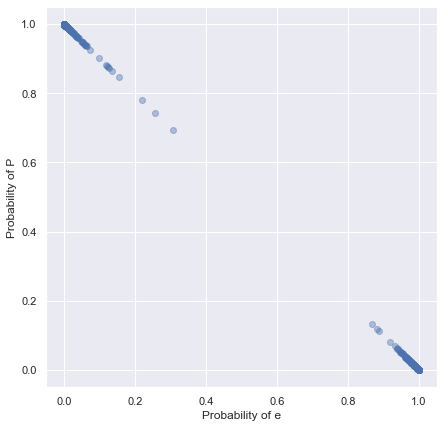

In [16]:
p = logreg.predict_proba(x_test)
probability_e = p[:,0]
probability_p = p[:,1] # p is 1, since p is poisonous

plt.figure(figsize=(7,7))
plt.scatter(probability_e, probability_p, alpha=.4)
plt.xlabel('Probability of e')
plt.ylabel('Probability of P')
plt.show()

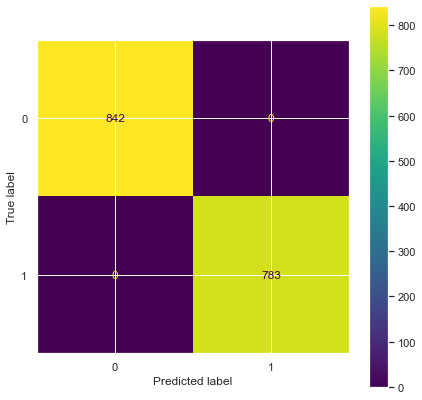

In [17]:
plt.rcParams['figure.figsize']=(7, 7) 
plot_confusion_matrix(logreg, x_test, y_test)  
plt.show() 

In [18]:
print(confusion_matrix(y_test, y_test_hat))

[[842   0]
 [  0 783]]


In [19]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



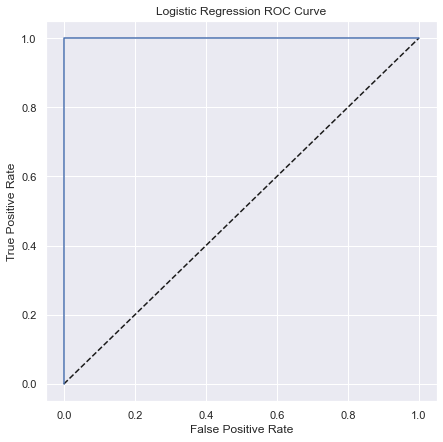

area under roc curve: 1.0


In [20]:
fpr, tpr, thresholds = roc_curve(y_test, probability_p)
plt.figure(figsize=(7,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()
print('area under roc curve:',roc_auc_score(y_test, probability_p))

The results of the accuracy tests, confusion matrix, and ROC curve all look perfect.

However this is only done on a single fold of data. The next section will examine the performance of the model with cross validation

# Hypertuning parameters with 10-fold cross validation
* Untuned log_reg model (above)
* Grid search cross-validation split tuned model
* Random search cross-validation split tuned model

In [21]:
scores = cross_val_score(logreg, x, y, cv=10, scoring='roc_auc')
print("%0.6f accuracy with a standard deviation of %0.6f" % (scores.mean(), scores.std()))

0.999793 accuracy with a standard deviation of 0.000620


In [22]:
lr = LogisticRegression()
para = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter':[100, 200]}

lr_gridsearch = GridSearchCV(lr, param_grid=para, scoring='accuracy', cv=10)

In [23]:
lr_gridsearch.fit(x_train, y_train)
print(lr_gridsearch.best_estimator_.get_params())
print(lr_gridsearch.score(x_test, y_test))
train_acc = accuracy_score(y_train, lr_gridsearch.predict(x_train))
test_acc = accuracy_score(y_test, lr_gridsearch.predict(x_test))
print('-----------------------------------------')
print(f"training set accuracy: {train_acc}")
print(f"testing set accuracy: {test_acc}")

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
1.0
-----------------------------------------
training set accuracy: 1.0
testing set accuracy: 1.0


In [24]:
scores = cross_val_score(lr_gridsearch.best_estimator_, x, y, cv=10, scoring='roc_auc')
print("Cross validation: %0.6f accuracy with a standard deviation of %0.6f" % (scores.mean(), scores.std()))

Cross validation: 0.999789 accuracy with a standard deviation of 0.000632


In [25]:
lr = LogisticRegression()
params = {
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs'],
    'max_iter':[100, 200]}

lr_randomsearch = RandomizedSearchCV(lr, param_distributions=params, scoring='accuracy', cv=10)

In [26]:
lr_randomsearch.fit(x_train, y_train)
print(lr_randomsearch.best_estimator_.get_params())
print(lr_randomsearch.score(x_test, y_test))
train_acc = accuracy_score(y_train, lr_randomsearch.predict(x_train))
test_acc = accuracy_score(y_test, lr_randomsearch.predict(x_test))
print('-----------------------------------------')
print(f"training set accuracy: {train_acc}")
print(f"testing set accuracy: {test_acc}")

D:\INSTALLATION_FOLDER\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
1.0
-----------------------------------------
training set accuracy: 1.0
testing set accuracy: 1.0


In [27]:
scores = cross_val_score(lr_randomsearch.best_estimator_, x, y, cv=10, scoring='roc_auc')
print("Cross validation: %0.6f accuracy with a standard deviation of %0.6f" % (scores.mean(), scores.std()))

Cross validation: 0.999793 accuracy with a standard deviation of 0.000620


The cross valildation results all have scores over 99% and negligible standard deviation of the tests. These are strong indicators that the model is working.